In [33]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random

In [34]:
np.random.seed(0)

In [35]:
data_location = './../../data/self_driving_car/german_traffic_signs/'

with open(data_location + 'train.p', 'rb') as f:
    train_data = pickle.load(f)

with open(data_location + 'valid.p', 'rb') as f:
    val_data = pickle.load(f)
    
with open(data_location + 'test.p', 'rb') as f:
    test_data = pickle.load(f)

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [36]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [37]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"

assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"
assert(X_val.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"

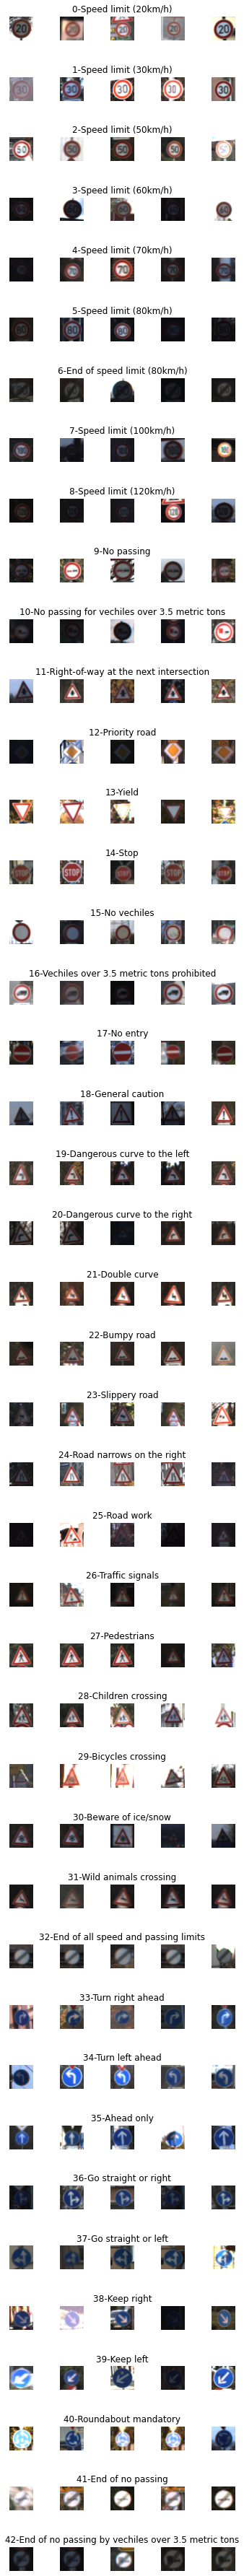

In [38]:
data = pd.read_csv(data_location + 'signnames.csv')

num_of_samples = []
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows = num_classes, ncols = cols, figsize = (5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected) - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["SignName"])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

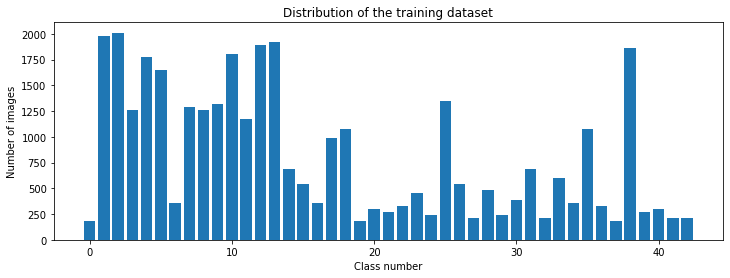

In [39]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")  

(32, 32, 3)
ClassId                        31
SignName    Wild animals crossing
Name: 31, dtype: object


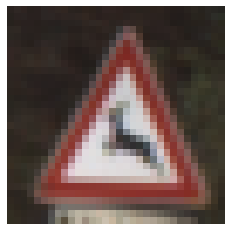

In [40]:
import cv2

plt.imshow(X_train[500])
plt.axis('off')
print(X_train[500].shape)
print(data.iloc[y_train[500]])

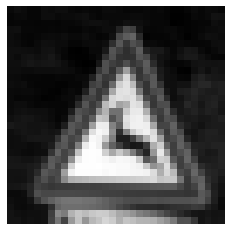

In [41]:
def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
image = grayscale(X_train[500])
plt.imshow(image, cmap="gray")
plt.axis('off')
plt.show()

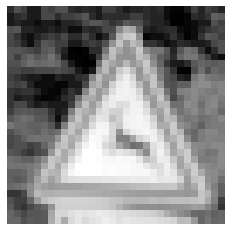

In [42]:
def equalize(image):
    return cv2.equalizeHist(image)

image = equalize(image)
plt.imshow(image, cmap="gray")
plt.axis('off')
plt.show()

In [43]:
def normalize(image):
    return image / 255

In [44]:
def preprocessing(image):
    image = grayscale(image)
    image = equalize(image)
    return normalize(image)

In [45]:
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

In [46]:
def is_grayscale(image):
    return True if len(image.shape) < 3 else False

def show_grayscale_image(image):
    plt.imshow(image, cmap="gray")
    plt.axis('off')
    plt.show()
    
def show_rgb_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
def show_image(image):
    if is_grayscale(image):
        show_grayscale_image(image)
    else:
        show_rgb_image(image)

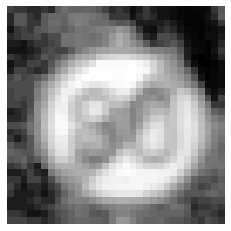

(34799, 32, 32)


In [47]:
show_image(X_train[random.randint(0, len(X_train) - 1)])
print(X_train.shape)

In [48]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [49]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    width_shift_range = 0.1, 
    height_shift_range = 0.1,
    zoom_range = 0.2,
    shear_range = 0.1,
    rotation_range = 10
)

datagen.fit(X_train)

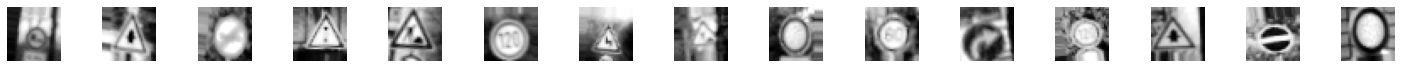

In [50]:
batches = datagen.flow(X_train, y_train, batch_size = 20)
X_batch, y_batch = next(batches)

fig, axis = plt.subplots(1, 15, figsize = (20, 5))
fig.tight_layout()

for i in range(15):
    axis[i].imshow(X_batch[i].reshape(32, 32), cmap=plt.get_cmap("gray"))
    axis[i].axis('off')

In [51]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [52]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [53]:
def leNet_model():
    model = Sequential()
    
    model.add(
        Conv2D(
            60, 
            (5, 5), 
            input_shape = (32, 32, 1), 
            activation = 'relu'
        )
    )
    
    model.add(
        MaxPooling2D(
            pool_size = (2, 2)
        )
    )
    
    model.add(
        Conv2D(
            30,
            (3, 3),
            activation = 'relu'
        )
    )
    
    model.add(
        MaxPooling2D(
            pool_size = (2, 2)
        )
    )
    
    model.add(Flatten())
    
    model.add(
        Dense(
            500, 
            activation = 'relu'
        )
    )
    
    model.add(Dropout(0.5))
    
    model.add(
        Dense(
            num_classes, 
            activation = 'softmax'
        )
    )
    
    model.compile(
        Adam(lr = 0.001),
        loss = 'categorical_crossentropy', 
        metrics = ['accuracy']
    )
    
    return model
    

In [62]:
def modified_model():
    model = Sequential()
    
    model.add(Conv2D(60, (5, 5), input_shape = (32, 32, 1), activation = 'relu'))
    model.add(Conv2D(60, (5, 5), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Conv2D(30, (3, 3), activation = 'relu'))
    model.add(Conv2D(30, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
#     model.add(Dropout(0.5))
    
    model.add(Flatten())
    
    model.add(Dense(500, activation = 'relu'))
    
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation = 'softmax'))
    
    model.compile(
        Adam(lr = 0.001),
        loss = 'categorical_crossentropy', 
        metrics = ['accuracy']
    )
    
    return model

In [63]:
model = modified_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 480)              

In [64]:
#steps_per_epoch = int(len(X_train)/batch_size)

history = model.fit_generator(
    datagen.flow(X_train, y_train, batch_size = 50),
    steps_per_epoch = 695,
    epochs = 10,
    validation_data = (X_val, y_val),
    shuffle = 1
)

Epoch 1/10
695/695 [==============================] - 108s 156ms/step - loss: 1.7708 - accuracy: 0.5025 - val_loss: 0.2618 - val_accuracy: 0.9202
Epoch 2/10
695/695 [==============================] - 112s 161ms/step - loss: 0.5435 - accuracy: 0.8367 - val_loss: 0.1362 - val_accuracy: 0.9560
Epoch 3/10
695/695 [==============================] - 107s 154ms/step - loss: 0.3377 - accuracy: 0.8984 - val_loss: 0.0869 - val_accuracy: 0.9717
Epoch 4/10
695/695 [==============================] - 106s 152ms/step - loss: 0.2591 - accuracy: 0.9202 - val_loss: 0.0774 - val_accuracy: 0.9762
Epoch 5/10
695/695 [==============================] - 107s 153ms/step - loss: 0.2033 - accuracy: 0.9388 - val_loss: 0.0450 - val_accuracy: 0.9871
Epoch 6/10
695/695 [==============================] - 107s 153ms/step - loss: 0.1656 - accuracy: 0.9500 - val_loss: 0.0478 - val_accuracy: 0.9857
Epoch 7/10
695/695 [==============================] - 105s 151ms/step - loss: 0.1588 - accuracy: 0.9517 - val_loss: 0.0354 -

In [ ]:
# history = model.fit(
#     X_train, 
#     y_train, 
#     epochs = 10, 
#     validation_data = (X_val, y_val), 
#     batch_size = 400,
#     verbose = 1,
#     shuffle = 1
# )

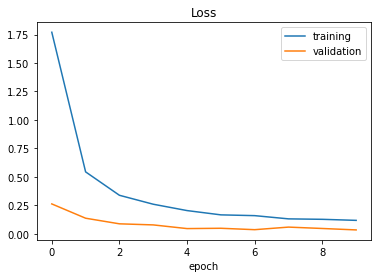

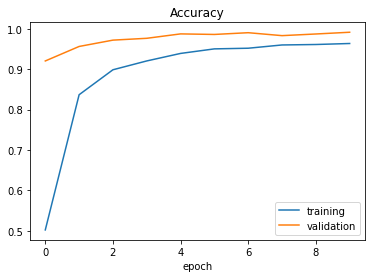

In [65]:
def show_model_loss_plot(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['training', 'validation'])
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.show()
    
def show_model_accuracy_plot(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['training', 'validation'])
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.show()

show_model_loss_plot(history)
show_model_accuracy_plot(history)

In [66]:
score = model.evaluate(X_test, y_test, verbose = 0)

print('Test Score: ', score[0])
print('Test Accuracy: ', score[1])

Test Score:  0.10344171524047852
Test Accuracy:  0.9722090363502502


In [67]:
model.save('../../models/cnn/self_driving_car') 

INFO:tensorflow:Assets written to: ../../models/cnn/self_driving_car/assets
